# GAT node classification with pytorch

## import packages

In [689]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
import os
import urllib.request
import tarfile

## download Cora dataset

In [690]:
!wget "https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz" -O cora.tgz
!tar -xvzf cora.tgz

--2023-08-06 00:58:52--  https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz
Resolving linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)... 128.114.47.74
Connecting to linqs-data.soe.ucsc.edu (linqs-data.soe.ucsc.edu)|128.114.47.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168052 (164K) [application/x-gzip]
Saving to: 'cora.tgz'

     0K .......... .......... .......... .......... .......... 30%  109K 1s
    50K .......... .......... .......... .......... .......... 60%  109K 1s
   100K .......... .......... .......... .......... .......... 91%  110K 0s
   150K .......... ....                                       100% 23.4M=1.4s

2023-08-06 00:58:54 (120 KB/s) - 'cora.tgz' saved [168052/168052]

x cora/
x cora/README
x cora/cora.cites
x cora/cora.content


In [691]:
data_dir = "cora"

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

In [692]:
# subjectのリナンバリング 
class_idx = {name: id for id, name in enumerate(sorted(papers["subject"].unique()))}
# paperのリナンバリング
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

In [693]:
papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

In [694]:
features = np.array(papers.iloc[:, 1:-1])
edges = np.array(citations[["target","source"]])
labels = np.array(papers["subject"])

In [695]:
n_features = features.shape[1]
n_classes = len(np.unique(labels))
n_nodes = features.shape[0]

In [696]:
features = torch.from_numpy(features).float()
edges = torch.from_numpy(edges)
labels = torch.from_numpy(labels)

In [697]:
indices = np.array([i for i in range(n_nodes)])

In [698]:
boolean = [True] * train_length + [False] * (n_nodes-train_length)

In [732]:
#データセットの分割
# train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.5, stratify=labels)
train_length = int(0.5*n_nodes)
np.random.shuffle(boolean)
indices_bool = torch.from_numpy(np.array(boolean))
indices_bool

tensor([ True, False,  True,  ..., False, False, False])

## Implement Dataloader

In [733]:
# データセットのクラス
class CoraDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [734]:
train_dataset = CoraDataset(train_features,train_labels)
test_dataset = CoraDataset(test_features,test_labels)

## Implement Graph Attention Layer

In [776]:
# Graph Attention Layer
class GraphAttention(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.6, alpha=0.2):
        super(GraphAttention, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.dropout = dropout
        self.alpha = alpha

        self.W = nn.Parameter(torch.empty(size=(in_features, out_features)))
        self.a = nn.Parameter(torch.empty(size=(2*out_features, 1)))

        self.leakyrelu = nn.LeakyReLU(self.alpha)

        self.init_weights()

    def init_weights(self):
        torch.nn.init.xavier_uniform_(self.W.data, gain=1.414)
        torch.nn.init.xavier_uniform_(self.a.data, gain=1.414)

    def forward(self, inputs, edges):
        # 線形変換
        #print(f"inputs.size():{inputs.size()},self.W.size():{self.W.size()}")
        z = torch.mm(inputs,self.W)
        #print(z.shape)

        # e_ijの計算
        edges_new_axis = edges.reshape(edges.shape[0],edges.shape[1],-1)
        edges_expand = edges_new_axis.expand(edges.shape[0],edges.shape[1],z.shape[1])
        z_new_axis = z.reshape(z.shape[0],-1,z.shape[1])
        z_expand = z_new_axis.expand(z.shape[0],edges.shape[1],z.shape[1])
        features_previous_concat = torch.gather(z_expand,0,edges_expand)
        #print(f"features_previous_concat.size():{features_previous_concat.size()}")
        features_concat = features_previous_concat.reshape(edges.shape[0],-1)
        #print(features_concat.shape)
        attention_score = leakyrelu(torch.mm(features_concat,a))
        #print(f"attention_score.size():{attention_score.size()}")

        # 正規化
        E = torch.tensor([np.where(edges[:,0]==i,1,0) for i in range(n_nodes)]).float()
        attention_score_sum_expand = torch.mm(torch.transpose(E,1,0),torch.mm(E,torch.exp(attention_score)))
        attention_score_norm = attention_score/attention_score_sum_expand
        #print(f"attention_score_noem.size():{attention_score_norm.size()}")

        # z_jの更新
        to_renew_z = attention_score_norm * features_previous_concat[:,1::2,:].reshape(-1,out_features)
        #print(f"to_renew_z.size():{to_renew_z.size()}")
        D = torch.tensor([np.where(edges[:,1]==j,1,0) for j in range(n_nodes)]).float()
        #print(f"D.size():{D.size()}")
        out = z + torch.matmul(D,to_renew_z)
        #print(f"out.size() of {self.__class__.__name__}:{out.size()}")
    
        return out

In [777]:
# Multi-Head Graph Attention Layer
class MultiHeadGraphAttention(nn.Module):
    def __init__(self, in_features, n_hidden, n_heads, merge_type="concat", dropout=0.6, alpha=0.2):
        super(MultiHeadGraphAttention, self).__init__()
        self.n_heads = n_heads
        self.heads = nn.ModuleList([GraphAttention(in_features, n_hidden, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        self.merge_type = merge_type

    def forward(self, inputs, edges):
        head_outs = [head(inputs, edges) for head in self.heads]
        #print(f"head_outs.size() of {self.__class__.__name__}:{torch.tensor(head_outs).size()}")
        if self.merge_type == "concat":
            out = torch.cat(head_outs, dim=1)
        else:
            out =  torch.mean(torch.stack(head_outs), dim=0)
        #print(f"out.size() of {self.__class__.__name__}:{out.size()}")
        return F.relu(out)

In [778]:
# Graph Attention Network
class GAT(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden, n_heads, dropout=0.6, alpha=0.2):
        super(GAT, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.n_hidden = n_hidden
        self.n_heads = n_heads
        self.dropout = dropout
        self.alpha = alpha
        self.preprocess = nn.Linear(n_features, n_hidden * n_heads)
        self.relu = F.relu
        self.attentions = nn.ModuleList([MultiHeadGraphAttention(n_hidden*n_heads, n_hidden, n_heads, dropout=dropout, alpha=alpha) for _ in range(n_heads)])
        #self.out_att = GraphAttention(n_hidden*n_heads, n_classes, dropout=dropout, alpha=alpha)
        self.output = nn.Linear(n_hidden * n_heads, n_classes)

    def forward(self, inputs, edges):
        x = self.preprocess(inputs)
        x = self.relu(x)
        for att in self.attentions:
            x = att(x, edges) + x
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.output(x)
        return F.log_softmax(x, dim=1)

In [786]:
# モデルの定義
n_hidden = 8
n_heads = 3
model = GAT(n_features, n_classes, n_hidden, n_heads)

## Model Training and Evaluating

In [780]:
# モデルの学習
def train_model(model, optimizer, criterion, indices, data_length, features, labels, edges):
    model.train()
    total_loss = 0.0
    features, labels = features.to(device), labels.to(device)
    output = model(features, edges)
    loss = criterion(output[indices], labels[indices])
    loss.backward()
    optimizer.step()
    total_loss += loss.item() * features.size(0)
    pred = output[indices].argmax(dim=1, keepdim=True)
    correct += pred.eq(labels[indices].view_as(pred)).sum().item()
    return total_loss / data_length, correct / data_length

# モデルの評価
def evaluate_model(model, criterion, indices, data_length, features, labels, edges):
    model.eval()
    total_loss = 0.0
    correct = 0
    with torch.no_grad():
        features, labels = features.to(device), labels.to(device)
        output = model(features, edges)
        loss = criterion(output[indices], labels[indices])
        total_loss += loss.item() * features.size(0)
        pred = output[indices].argmax(dim=1, keepdim=True)
        correct += pred.eq(labels[indices].view_as(pred)).sum().item()

    return total_loss / data_length, correct / data_length

In [781]:
# 損失関数と最適化手法の定義
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

In [782]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [787]:
# モデルの学習と評価
n_epochs = 100
model = model.to(device)

In [793]:
from torchinfo import summary
summary(model=model,depth=4)

Layer (type:depth-idx)                   Param #
GAT                                      --
├─Linear: 1-1                            34,416
├─ModuleList: 1-2                        --
│    └─MultiHeadGraphAttention: 2-1      --
│    │    └─ModuleList: 3-1              --
│    │    │    └─GraphAttention: 4-1     208
│    │    │    └─GraphAttention: 4-2     208
│    │    │    └─GraphAttention: 4-3     208
│    └─MultiHeadGraphAttention: 2-2      --
│    │    └─ModuleList: 3-2              --
│    │    │    └─GraphAttention: 4-4     208
│    │    │    └─GraphAttention: 4-5     208
│    │    │    └─GraphAttention: 4-6     208
│    └─MultiHeadGraphAttention: 2-3      --
│    │    └─ModuleList: 3-3              --
│    │    │    └─GraphAttention: 4-7     208
│    │    │    └─GraphAttention: 4-8     208
│    │    │    └─GraphAttention: 4-9     208
├─Linear: 1-3                            175
Total params: 36,463
Trainable params: 36,463
Non-trainable params: 0

In [785]:
from torch.utils.tensorboard import SummaryWriter
import datetime
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
now = datetime.datetime.now(JST)
writer = SummaryWriter(log_dir=f"./logs/{now:%Y%m%d%H%M}")

for epoch in range(n_epochs):
    train_loss, train_accuracy  = train_model(model, optimizer, criterion, indices, train_length, features, labels, edges)
    test_loss, test_accuracy = evaluate_model(model, criterion, (indices==False), n_nodes-train_length, features, labels, edges)
    print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    writer.add_scalar("train/loss",train_loss,epoch)
    writer.add_scalar("train/accuracy",train_accuracy,epoch)
    writer.add_scalar("test/loss",test_loss,epoch)
    writer.add_scalar("test/accuracy",test_accuracy,epoch)
    
writer.close()

inputs.size():torch.Size([2708, 24]),self.W.size():torch.Size([24, 8])
torch.Size([2708, 8])
features_previous_concat.size():torch.Size([5429, 2, 8])
attention_score.size():torch.Size([5429, 1])
attention_score_noem.size():torch.Size([5429, 1])
to_renew_z.size():torch.Size([5429, 8])
D.size():torch.Size([2708, 5429])
out.size() of GraphAttention:torch.Size([2708, 8])
inputs.size():torch.Size([2708, 24]),self.W.size():torch.Size([24, 8])
torch.Size([2708, 8])
features_previous_concat.size():torch.Size([5429, 2, 8])
attention_score.size():torch.Size([5429, 1])
attention_score_noem.size():torch.Size([5429, 1])
to_renew_z.size():torch.Size([5429, 8])
D.size():torch.Size([2708, 5429])
out.size() of GraphAttention:torch.Size([2708, 8])
inputs.size():torch.Size([2708, 24]),self.W.size():torch.Size([24, 8])
torch.Size([2708, 8])
features_previous_concat.size():torch.Size([5429, 2, 8])
attention_score.size():torch.Size([5429, 1])
attention_score_noem.size():torch.Size([5429, 1])
to_renew_z.size

KeyboardInterrupt: 

In [ ]:
#tensorboard --logdir="./logs/hogehoge"

# for debug

## Graph Attention Layerの計算

In [ ]:
features.shape,edges.shape,labels.shape

(torch.Size([2708, 1433]), torch.Size([5429, 2]), torch.Size([2708]))

### 0: 線形変換

In [ ]:
in_features = n_features
out_features = n_hidden
W = torch.randn(size=(in_features, out_features))
W.shape

torch.Size([1433, 8])

In [ ]:
z = torch.mm(features,W)
z.shape

torch.Size([2708, 8])

### 1: $e_{ij}$の計算

In [ ]:
edges_new_axis = edges.reshape(edges.shape[0],edges.shape[1],-1)
edges_expand = edges_new_axis.expand(edges.shape[0],edges.shape[1],z.shape[1])
edges_expand,edges_expand.shape

(tensor([[[   0,    0,    0,  ...,    0,    0,    0],
          [  21,   21,   21,  ...,   21,   21,   21]],
 
         [[   0,    0,    0,  ...,    0,    0,    0],
          [ 905,  905,  905,  ...,  905,  905,  905]],
 
         [[   0,    0,    0,  ...,    0,    0,    0],
          [ 906,  906,  906,  ...,  906,  906,  906]],
 
         ...,
 
         [[1874, 1874, 1874,  ..., 1874, 1874, 1874],
          [2586, 2586, 2586,  ..., 2586, 2586, 2586]],
 
         [[1876, 1876, 1876,  ..., 1876, 1876, 1876],
          [1874, 1874, 1874,  ..., 1874, 1874, 1874]],
 
         [[1897, 1897, 1897,  ..., 1897, 1897, 1897],
          [2707, 2707, 2707,  ..., 2707, 2707, 2707]]]),
 torch.Size([5429, 2, 8]))

In [ ]:
z_new_axis = z.reshape(z.shape[0],-1,z.shape[1])
z_expand = z_new_axis.expand(z.shape[0],edges.shape[1],z.shape[1])
z_expand, z_expand.shape

(tensor([[[ 1.9098,  0.9079,  0.9501,  ..., 10.9173,  2.3840, -1.4820],
          [ 1.9098,  0.9079,  0.9501,  ..., 10.9173,  2.3840, -1.4820]],
 
         [[-3.4538, -4.3552, -3.0108,  ..., -2.4590, -0.3970, -1.2268],
          [-3.4538, -4.3552, -3.0108,  ..., -2.4590, -0.3970, -1.2268]],
 
         [[ 6.3808,  0.3100, -0.9094,  ..., -2.3816, -4.8970,  0.5370],
          [ 6.3808,  0.3100, -0.9094,  ..., -2.3816, -4.8970,  0.5370]],
 
         ...,
 
         [[ 2.5645, -2.1831, -3.7584,  ..., -7.9192, -1.1197,  3.4378],
          [ 2.5645, -2.1831, -3.7584,  ..., -7.9192, -1.1197,  3.4378]],
 
         [[ 4.8376, -3.3433, -1.5954,  ...,  0.3057, -4.9777, -0.2487],
          [ 4.8376, -3.3433, -1.5954,  ...,  0.3057, -4.9777, -0.2487]],
 
         [[-9.4363,  1.1044,  6.1770,  ..., -5.2679,  7.6996, -0.5346],
          [-9.4363,  1.1044,  6.1770,  ..., -5.2679,  7.6996, -0.5346]]]),
 torch.Size([2708, 2, 8]))

$features\_previous\_concat[i][j][k] = z\_expand[edges\_expand[i][j][k]][j][k]$

$features\_concat[i] = [features\_previous\_concat[i][0] || features\_previous\_concat[i][1]] = [z[edges[0]] || z[edges[1]]]$

In [ ]:
features_previous_concat = torch.gather(z_expand,0,edges_expand)
features_previous_concat

tensor([[[ 1.9098e+00,  9.0787e-01,  9.5011e-01,  ...,  1.0917e+01,
           2.3840e+00, -1.4820e+00],
         [-1.1673e-01,  8.3575e-01,  2.2723e+00,  ..., -3.6076e+00,
          -2.7866e-01, -7.8429e-01]],

        [[ 1.9098e+00,  9.0787e-01,  9.5011e-01,  ...,  1.0917e+01,
           2.3840e+00, -1.4820e+00],
         [ 1.1090e+00,  1.9547e+00, -1.0038e+00,  ...,  3.1264e+00,
          -3.6850e-01,  1.0583e+00]],

        [[ 1.9098e+00,  9.0787e-01,  9.5011e-01,  ...,  1.0917e+01,
           2.3840e+00, -1.4820e+00],
         [ 1.2936e-02,  3.3463e+00,  3.0718e+00,  ...,  6.8319e+00,
          -1.5667e+00, -1.2071e+00]],

        ...,

        [[ 2.8806e+00,  5.4618e-01, -8.9918e+00,  ..., -8.0656e+00,
          -7.9111e-01,  2.9114e+00],
         [-7.5609e-02,  1.9678e-01, -9.0859e+00,  ..., -3.0945e+00,
           1.9150e+00, -3.9001e+00]],

        [[ 4.2383e-01,  4.7445e-01, -2.5989e+00,  ..., -7.9082e+00,
           2.1607e+00,  2.9065e+00],
         [ 2.8806e+00,  5.4618e-0

In [ ]:
features_concat = features_previous_concat.reshape(edges.shape[0],-1)
features_concat.shape

torch.Size([5429, 16])

$LeakyReLU(x)=max(0,x)+negative\_slope∗min(0,x)$

Reference:https://pytorch.org/docs/stable/generated/torch.nn.functional.leaky_relu.html

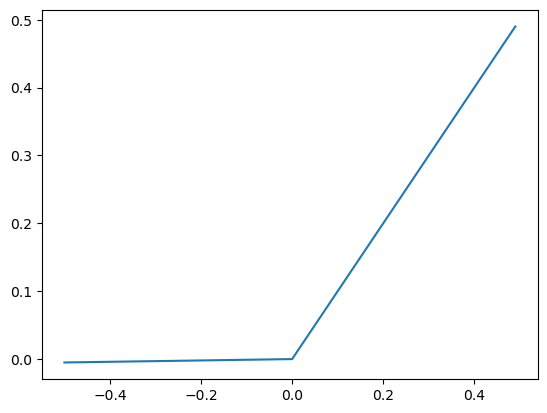

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

negative_slope = 0.01 #default value
X = np.arange(-0.5,0.5,0.01)
LeakyReLU = np.maximum(X,0) + negative_slope*np.minimum(X,0)
plt.plot(X,LeakyReLU)

In [ ]:
#LeakyReluの適用
a = torch.randn(size=(2*out_features, 1))
alpha = 0.2
leakyrelu = nn.LeakyReLU(alpha)
attention_score = leakyrelu(torch.mm(features_concat,a))
attention_score, attention_score.shape

(tensor([[ 6.4770],
         [ 0.7722],
         [-1.4811],
         ...,
         [ 7.4192],
         [11.7632],
         [ 9.1880]]),
 torch.Size([5429, 1]))

### 2: 正規化

$edges[k]=[i,j]$のとき$attention\_score[k] = e_{ij}$

$E_{kl} = 
  \begin{cases}
    1 & \quad \textrm{if } edges[k][0]==l \\
    0                 & \quad \textrm{otherwise}
  \end{cases}
$

$e\_sum_i = \sum_j exp(e_{ij}) = E exp(e_{ij})$

In [ ]:
E = torch.tensor([np.where(edges[:,0]==i,1,0) for i in range(n_nodes)]).float()
E, E.shape

(tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 torch.Size([2708, 5429]))

In [ ]:
attention_score_sum = torch.matmul(E,torch.exp(attention_score))
attention_score_sum, attention_score_sum.shape

(tensor([[3.6907e+13],
         [2.8349e-01],
         [1.1490e+17],
         ...,
         [0.0000e+00],
         [0.0000e+00],
         [0.0000e+00]]),
 torch.Size([2708, 1]))

In [ ]:
attention_score_sum_expand = torch.matmul(torch.transpose(E,1,0),attention_score_sum)
attention_score_sum_expand, attention_score_sum_expand.shape

(tensor([[3.6907e+13],
         [3.6907e+13],
         [3.6907e+13],
         ...,
         [1.6677e+03],
         [1.2844e+05],
         [9.7789e+03]]),
 torch.Size([5429, 1]))

In [ ]:
attention_score_norm = attention_score/attention_score_sum_expand
attention_score_norm, attention_score_norm.shape

(tensor([[ 1.7550e-13],
         [ 2.0923e-14],
         [-4.0130e-14],
         ...,
         [ 4.4487e-03],
         [ 9.1585e-05],
         [ 9.3957e-04]]),
 torch.Size([5429, 1]))

### 3: $z_j$ の更新

$to\_renew\_z_{e_{ij}} = norm(e_{ij})*\boldsymbol{h}_j$

In [ ]:
to_renew_z = attention_score_norm * features_previous_concat[:,1::2,:].reshape(-1,out_features)
to_renew_z, to_renew_z.shape

(tensor([[-2.0486e-14,  1.4667e-13,  3.9879e-13,  ..., -6.3312e-13,
          -4.8903e-14, -1.3764e-13],
         [ 2.3204e-14,  4.0899e-14, -2.1002e-14,  ...,  6.5414e-14,
          -7.7103e-15,  2.2144e-14],
         [-5.1910e-16, -1.3429e-13, -1.2327e-13,  ..., -2.7416e-13,
           6.2873e-14,  4.8442e-14],
         ...,
         [-3.3636e-04,  8.7543e-04, -4.0421e-02,  ..., -1.3767e-02,
           8.5191e-03, -1.7350e-02],
         [ 2.6382e-04,  5.0022e-05, -8.2351e-04,  ..., -7.3869e-04,
          -7.2454e-05,  2.6664e-04],
         [-8.8660e-03,  1.0377e-03,  5.8038e-03,  ..., -4.9496e-03,
           7.2343e-03, -5.0229e-04]]),
 torch.Size([5429, 8]))

In [ ]:
D = torch.tensor([np.where(edges[:,1]==j,1,0) for j in range(n_nodes)]).float()
D, D.shape

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 1.]]),
 torch.Size([2708, 5429]))

In [ ]:
out = z + torch.matmul(D,to_renew_z)
out, out.shape

(tensor([[  1.9098,   0.9079,   0.9501,  ...,  10.9173,   2.3840,  -1.4820],
         [ -3.4538,  -4.3552,  -3.0108,  ...,  -2.4590,  -0.3970,  -1.2268],
         [  6.3808,   0.3100,  -0.9094,  ...,  -2.3816,  -4.8970,   0.5370],
         ...,
         [  2.5645,  -2.1831,  -3.7584,  ...,  -7.9192,  -1.1197,   3.4378],
         [  2.2302,  -1.5413,  -0.7355,  ...,   0.1409,  -2.2948,  -0.1147],
         [-12.0314,   1.4081,   7.8758,  ...,  -6.7166,   9.8171,  -0.6816]]),
 torch.Size([2708, 8]))

## Graph Attention Layerのまとめ

In [ ]:
# 線形変換
z = torch.mm(features,W)

# e_ijの計算
edges_new_axis = edges.reshape(edges.shape[0],edges.shape[1],-1)
edges_expand = edges_new_axis.expand(edges.shape[0],edges.shape[1],z.shape[1])
z_new_axis = z.reshape(z.shape[0],-1,z.shape[1])
z_expand = z_new_axis.expand(z.shape[0],edges.shape[1],z.shape[1])
features_previous_concat = torch.gather(z_expand,0,edges_expand)
features_concat = features_previous_concat.reshape(edges.shape[0],-1)
attention_score = leakyrelu(torch.mm(features_concat,a))

# 正規化
E = torch.tensor([np.where(edges[:,0]==i,1,0) for i in range(n_nodes)]).float()
attention_score_sum_expand = torch.mm(torch.transpose(E,1,0),torch.mm(E,torch.exp(attention_score)))
attention_score_norm = attention_score/attention_score_sum_expand

# z_jの更新
to_renew_z = attention_score_norm * features_previous_concat[:,1::2,:].reshape(edges.shape[0],-1)
D = torch.tensor([np.where(edges[:,1]==j,1,0) for j in range(n_nodes)]).float()
out = z + torch.matmul(D,to_renew_z)

In [ ]:
out.shape

torch.Size([2708, 8])

## torch.catについて

In [ ]:
head_out = [torch.arange(0,2708*8).reshape(2708,8) for _ in range(n_heads)]
head_out

[tensor([[    0,     1,     2,  ...,     5,     6,     7],
         [    8,     9,    10,  ...,    13,    14,    15],
         [   16,    17,    18,  ...,    21,    22,    23],
         ...,
         [21640, 21641, 21642,  ..., 21645, 21646, 21647],
         [21648, 21649, 21650,  ..., 21653, 21654, 21655],
         [21656, 21657, 21658,  ..., 21661, 21662, 21663]]),
 tensor([[    0,     1,     2,  ...,     5,     6,     7],
         [    8,     9,    10,  ...,    13,    14,    15],
         [   16,    17,    18,  ...,    21,    22,    23],
         ...,
         [21640, 21641, 21642,  ..., 21645, 21646, 21647],
         [21648, 21649, 21650,  ..., 21653, 21654, 21655],
         [21656, 21657, 21658,  ..., 21661, 21662, 21663]]),
 tensor([[    0,     1,     2,  ...,     5,     6,     7],
         [    8,     9,    10,  ...,    13,    14,    15],
         [   16,    17,    18,  ...,    21,    22,    23],
         ...,
         [21640, 21641, 21642,  ..., 21645, 21646, 21647],
         [

In [ ]:
torch.cat(head_out,dim=1),torch.cat(head_out,dim=0)

(tensor([[    0,     1,     2,  ...,     5,     6,     7],
         [    8,     9,    10,  ...,    13,    14,    15],
         [   16,    17,    18,  ...,    21,    22,    23],
         ...,
         [21640, 21641, 21642,  ..., 21645, 21646, 21647],
         [21648, 21649, 21650,  ..., 21653, 21654, 21655],
         [21656, 21657, 21658,  ..., 21661, 21662, 21663]]),
 tensor([[    0,     1,     2,  ...,     5,     6,     7],
         [    8,     9,    10,  ...,    13,    14,    15],
         [   16,    17,    18,  ...,    21,    22,    23],
         ...,
         [21640, 21641, 21642,  ..., 21645, 21646, 21647],
         [21648, 21649, 21650,  ..., 21653, 21654, 21655],
         [21656, 21657, 21658,  ..., 21661, 21662, 21663]]))

In [ ]:
torch.cat(head_out,dim=1).size(),torch.cat(head_out,dim=0).size()

(torch.Size([2708, 24]), torch.Size([8124, 8]))